# construct an Encoder–Decoder architecture in which the Encoder consists of five LSTM layers and the Decoder also consists of five LSTM layers, each with a hidden size of 256, for the Named Entity Recognition (NER) task. The model is trained on the PhoNER dataset, and its performance is evaluated using the F1 score.

In [1]:
!pip install seqeval

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from seqeval.metrics import f1_score as seq_f1_score
from seqeval.metrics import classification_report as seq_classification_report

from tqdm import tqdm

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
class EarlyStopping:
    """Early stopping to stop training when validation F1 doesn't improve"""
    def __init__(self, patience=5, min_delta=0.0001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_f1 = 0

    def __call__(self, val_f1, model, path='best_encoder_decoder_ner.pt'):
        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.best_f1 = val_f1
            self.save_checkpoint(val_f1, model, path)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_f1 = val_f1
            self.save_checkpoint(val_f1, model, path)
            self.counter = 0

    def save_checkpoint(self, val_f1, model, path):
        if self.verbose:
            print(f'  → Validation F1 improved ({self.best_f1:.4f} --> {val_f1:.4f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.best_f1 = val_f1

In [9]:
class Vocabulary:
    """Build vocabulary from training data"""
    def __init__(self, max_vocab_size=20000):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.max_vocab_size = max_vocab_size

    def build_vocab(self, sentences):
        """Build vocabulary from list of tokenized sentences"""
        word_freq = Counter()
        for sentence in sentences:
            word_freq.update(sentence)

        most_common = word_freq.most_common(self.max_vocab_size - 2)

        for idx, (word, _) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, sentence):
        """Convert sentence to list of indices"""
        return [self.word2idx.get(word, 1) for word in sentence]

vocab = Vocabulary(max_vocab_size=10)

sentences = [
    ["thầy", "giảng", "bài", "hay"],
    ["giảng", "viên", "nhiệt", "tình"]
]

vocab.build_vocab(sentences)

encoded = vocab.encode(["thầy", "giảng", "rất", "hay"])
print(encoded)

OUTPUT: 
Vocabulary size: 9
[3, 2, 1, 5]

In [22]:
class LabelEncoder:
    """Encode NER labels"""
    def __init__(self):
        self.label2idx = {"<PAD>": 0}
        self.idx2label = {0: "<PAD>"}

    def build_labels(self, labels_list):
        """Build label encoding from list of label sequences"""
        unique_labels = set()
        for labels in labels_list:
            unique_labels.update(labels)

        for idx, label in enumerate(sorted(unique_labels), start=1):
            self.label2idx[label] = idx
            self.idx2label[idx] = label

        print(f"Number of labels: {len(self.label2idx)}")
        print(f"Labels: {sorted(unique_labels)}")

    def encode(self, labels):
        """Convert labels to indices"""
        return [self.label2idx[label] for label in labels]

    def decode(self, indices):
        """Convert indices back to labels"""
        return [self.idx2label[idx] for idx in indices if idx != 0]

In [10]:
def load_json_or_jsonl(file_path):
    """
    Load either a JSON list file or a JSON Lines file.
    Returns a Python list of objects (dicts).
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().strip()
        if not text:
            return []
        # If starts with '[' -> whole-file JSON list
        if text.startswith('['):
            try:
                return json.loads(text)
            except json.JSONDecodeError:
                # fallback to line-by-line
                pass
        # Try to parse as JSONL (one JSON object per line)
        objs = []
        with open(file_path, 'r', encoding='utf-8') as ff:
            for line_no, line in enumerate(ff, start=1):
                line = line.strip()
                if not line:
                    continue
                try:
                    objs.append(json.loads(line))
                except json.JSONDecodeError as e:
                    # give helpful message and re-raise
                    raise json.JSONDecodeError(f"Error parsing JSON at line {line_no} in {file_path}: {e.msg}", e.doc, e.pos)
        return objs

In [11]:
class PhoNERDataset(Dataset):
    """Dataset class for PhoNER (JSON or JSONL format)"""
    def __init__(self, file_path, vocab=None, label_encoder=None, is_train=False):
        # Load JSON/JSONL file
        data = load_json_or_jsonl(file_path)

        self.sentences = []
        self.labels = []

        # Parse various JSON formats commonly seen
        for item in data:
            # skip non-dicts or empty
            if not isinstance(item, dict):
                continue
            # prefer common key combos: 'words'/'tags', 'words'/'ner_tags', 'tokens'/'tags'
            if 'words' in item and 'tags' in item:
                self.sentences.append(item['words'])
                self.labels.append(item['tags'])
            elif 'words' in item and 'ner_tags' in item:
                self.sentences.append(item['words'])
                self.labels.append(item['ner_tags'])
            elif 'tokens' in item and 'tags' in item:
                self.sentences.append(item['tokens'])
                self.labels.append(item['tags'])
            elif 'tokens' in item and 'ner_tags' in item:
                self.sentences.append(item['tokens'])
                self.labels.append(item['ner_tags'])
            else:
                # if format unknown, try to find any list-like fields
                # this is a fallback and conservative
                possible_words = None
                possible_tags = None
                for k, v in item.items():
                    if isinstance(v, list) and all(isinstance(x, str) for x in v) and possible_words is None:
                        possible_words = v
                    elif isinstance(v, list) and all(isinstance(x, str) for x in v) and possible_tags is None:
                        possible_tags = v
                if possible_words is not None and possible_tags is not None and len(possible_words) == len(possible_tags):
                    self.sentences.append(possible_words)
                    self.labels.append(possible_tags)
                else:
                    # skip entries we can't parse
                    continue

        print(f"Loaded {len(self.sentences)} sentences from {file_path}")

        # Build vocabulary and label encoder on training set
        if is_train:
            self.vocab = Vocabulary()
            self.vocab.build_vocab(self.sentences)

            self.label_encoder = LabelEncoder()
            self.label_encoder.build_labels(self.labels)
        else:
            if vocab is None or label_encoder is None:
                raise ValueError("vocab and label_encoder must be provided for non-training datasets")
            self.vocab = vocab
            self.label_encoder = label_encoder

        # Encode sentences and labels
        self.encoded_sentences = [torch.tensor(self.vocab.encode(sent), dtype=torch.long) for sent in self.sentences]
        self.encoded_labels = [torch.tensor(self.label_encoder.encode(labels), dtype=torch.long) for labels in self.labels]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return (
            self.encoded_sentences[idx],
            self.encoded_labels[idx],
            self.sentences[idx],
            self.labels[idx]
        )

In [12]:
def collate_fn(batch):
    """Custom collate function to pad sequences"""
    sentences, labels, orig_words, orig_labels = zip(*batch)

    lengths = torch.tensor([len(s) for s in sentences])
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)

    return sentences_padded, labels_padded, lengths, orig_words, orig_labels

In [13]:
class EncoderLSTM(nn.Module):
    """5-layer LSTM Encoder with Dropout"""
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.5):
        super(EncoderLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_dropout = nn.Dropout(dropout * 0.5)
        self.hidden_size = hidden_size

        # 5 LSTM layers with dropout parameter
        self.lstm1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True,
                            bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True,
                            bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True,
                            bidirectional=True)
        self.lstm4 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True,
                            bidirectional=True)
        self.lstm5 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True,
                            bidirectional=True)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)

        out, _ = self.lstm1(embedded)
        out = self.dropout(out)

        out, _ = self.lstm2(out)
        out = self.dropout(out)

        out, _ = self.lstm3(out)
        out = self.dropout(out)

        out, _ = self.lstm4(out)
        out = self.dropout(out)

        out, (hidden, cell) = self.lstm5(out)

        out = self.layer_norm(out)

        return out, (hidden, cell)

In [14]:
class DecoderLSTM(nn.Module):
    """5-layer LSTM Decoder"""
    def __init__(self, num_labels, embedding_dim, hidden_size, dropout=0.6):
        super(DecoderLSTM, self).__init__()

        self.embedding = nn.Embedding(num_labels, embedding_dim, padding_idx=0)
        self.hidden_size = hidden_size

        # 5 LSTM layers
        self.lstm1 = nn.LSTM(hidden_size * 2 + embedding_dim, hidden_size,
                            batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm5 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_labels)

    def forward(self, encoder_outputs, labels):
        batch_size, seq_len = labels.size()

        # Teacher forcing: use previous label to predict next
        decoder_input = torch.zeros(batch_size, 1, dtype=torch.long, device=labels.device)
        decoder_input = torch.cat([decoder_input, labels[:, :-1]], dim=1)

        embedded = self.embedding(decoder_input)
        decoder_input_combined = torch.cat([encoder_outputs, embedded], dim=-1)

        out, _ = self.lstm1(decoder_input_combined)
        out = self.dropout(out)

        out, _ = self.lstm2(out)
        out = self.dropout(out)

        out, _ = self.lstm3(out)
        out = self.dropout(out)

        out, _ = self.lstm4(out)
        out = self.dropout(out)

        out, _ = self.lstm5(out)
        out = self.dropout(out)

        out = self.fc(out)
        return out

In [15]:
class EncoderDecoderNER(nn.Module):
    """5-layer Encoder + 5-layer Decoder LSTM for NER"""
    def __init__(self, vocab_size, num_labels, embedding_dim, hidden_size, dropout=0.5):
        super(EncoderDecoderNER, self).__init__()

        self.encoder = EncoderLSTM(vocab_size, embedding_dim, hidden_size, dropout)
        self.decoder = DecoderLSTM(num_labels, embedding_dim, hidden_size, dropout)

    def forward(self, sentences, labels, lengths):
        encoder_outputs, (hidden, cell) = self.encoder(sentences, lengths)
        decoder_outputs = self.decoder(encoder_outputs, labels)
        return decoder_outputs

In [25]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(
        dataloader,
        desc="Training",
        leave=False
    )

    for sentences, labels, lengths, _, _ in progress_bar:
        sentences = sentences.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = model(sentences, labels, lengths)

        outputs = outputs.view(-1, outputs.size(-1))
        labels_flat = labels.view(-1)

        loss = criterion(outputs, labels_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [26]:
def evaluate(model, dataloader, criterion, device, label_encoder):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(
        dataloader,
        desc="Evaluating",
        leave=False
    )

    with torch.no_grad():
        for sentences, labels, lengths, orig_words, orig_labels in progress_bar:
            sentences = sentences.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(sentences, labels, lengths)

            outputs_flat = outputs.view(-1, outputs.size(-1))
            labels_flat = labels.view(-1)
            loss = criterion(outputs_flat, labels_flat)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=-1)

            for i in range(len(sentences)):
                length = lengths[i].item()
                pred_labels = [label_encoder.idx2label[idx.item()]
                              for idx in preds[i][:length]]
                true_labels = list(orig_labels[i])

                all_preds.append(pred_labels)
                all_labels.append(true_labels)

    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_labels, all_preds)

    return avg_loss, f1, all_preds, all_labels

In [20]:
def main():
    # Hyperparameters
    EMBEDDING_DIM = 128
    HIDDEN_SIZE = 256
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    LEARNING_RATE = 5e-4
    PATIENCE = 7
    MIN_DELTA = 0.0001
    WEIGHT_DECAY = 1e-4
    DROPOUT_RATE = 0.75

    try:
        base_path = './dataset/PhoNER-COVID19/'
        print(f"Looking for data in: {base_path}")
    except:
        print("Not running ")
        base_path = './'

    try:
        train_dataset = PhoNERDataset(f'{base_path}train_syllable.json', is_train=True)
        dev_dataset = PhoNERDataset(f'{base_path}dev_syllable.json',
                                    vocab=train_dataset.vocab,
                                    label_encoder=train_dataset.label_encoder)
        test_dataset = PhoNERDataset(f'{base_path}test_syllable.json',
                                     vocab=train_dataset.vocab,
                                     label_encoder=train_dataset.label_encoder)
    except FileNotFoundError as e:
        print(f"\nError: {e}")
        print("\nPlease download PhoNER_COVID19 dataset from:")
        print("https://github.com/VinAIResearch/PhoNER_COVID19")
        print("\nExpected files: train_syllable.json, dev_syllable.json, test_syllable.json")
        return
    except json.JSONDecodeError as e:
        print(f"\nJSON parsing error: {e}")
        return

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE,
                           shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, collate_fn=collate_fn)

    # Initialize model
    vocab_size = len(train_dataset.vocab.word2idx)
    num_labels = len(train_dataset.label_encoder.label2idx)

    model = EncoderDecoderNER(vocab_size, num_labels, EMBEDDING_DIM,
                              HIDDEN_SIZE).to(device)
    print(f"\nModel architecture:\n{model}")
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max', # Giám sát F1 score (max)
    factor=0.5, # Giảm LR đi một nửa (hoặc 0.1)
    patience=3, # Nếu F1 không cải thiện sau 3 epoch thì giảm LR
    min_lr=1e-6, # Giới hạn tối thiểu của LR
)

    # Early stopping
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, verbose=True)

    # Training loop
    train_losses, dev_losses, dev_f1s = [], [], []

    print(f"\nStarting training with early stopping (patience={PATIENCE})...")
    for epoch in range(NUM_EPOCHS):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        dev_loss, dev_f1, _, _ = evaluate(model, dev_loader, criterion, device,
                                          train_dataset.label_encoder)

        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
        dev_f1s.append(dev_f1)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Dev Loss: {dev_loss:.4f}, Dev F1: {dev_f1:.4f}")

        scheduler.step(dev_f1)
        early_stopping(dev_f1, model)

        if early_stopping.early_stop:
            print(f"\n{'='*50}")
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation F1: {early_stopping.best_f1:.4f}")
            print(f"{'='*50}\n")
            break

    # Load best model and evaluate on test set
    print("Loading best model for test evaluation...")
    model.load_state_dict(torch.load('best_encoder_decoder_ner.pt'))
    test_loss, test_f1, test_preds, test_labels = evaluate(
        model, test_loader, criterion, device, train_dataset.label_encoder)

    print(f"\n{'='*50}")
    print(f"Final Test Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test F1: {test_f1:.4f}")
    print(f"  Best Dev F1: {early_stopping.best_f1:.4f}")
    print(f"  Total Epochs Trained: {len(train_losses)}")
    print(f"{'='*50}")

    print("\nDetailed Classification Report:")
    print(seq_classification_report(test_labels, test_preds))

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
    plt.plot(dev_losses, label='Dev Loss', marker='s', markersize=3)
    plt.axvline(x=len(train_losses) - PATIENCE - 1, color='r', linestyle='--',
                label='Best Model', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Encoder-Decoder Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(dev_f1s, label='Dev F1', marker='o', markersize=3)
    plt.axvline(x=len(dev_f1s) - PATIENCE - 1, color='r', linestyle='--',
                label='Best Model', alpha=0.7)
    plt.axhline(y=early_stopping.best_f1, color='g', linestyle=':',
                label=f'Best F1: {early_stopping.best_f1:.4f}', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Encoder-Decoder Validation F1 Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('encoder_decoder_training_curves.png', dpi=300, bbox_inches='tight')
    print("\nTraining curves saved as 'encoder_decoder_training_curves.png'")

Looking for data in: ./dataset/PhoNER-COVID19/
Loaded 5027 sentences from ./dataset/PhoNER-COVID19/train_syllable.json
Vocabulary size: 3967
Number of labels: 22
Labels: ['B-AGE', 'B-DATE', 'B-GENDER', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-ORGANIZATION', 'B-PATIENT_ID', 'B-SYMPTOM_AND_DISEASE', 'B-TRANSPORTATION', 'I-AGE', 'I-DATE', 'I-GENDER', 'I-JOB', 'I-LOCATION', 'I-NAME', 'I-ORGANIZATION', 'I-PATIENT_ID', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'O']
Loaded 2000 sentences from ./dataset/PhoNER-COVID19/dev_syllable.json
Loaded 3000 sentences from ./dataset/PhoNER-COVID19/test_syllable.json

Model architecture:
EncoderDecoderNER(
  (encoder): EncoderLSTM(
    (embedding): Embedding(3967, 128, padding_idx=0)
    (embedding_dropout): Dropout(p=0.25, inplace=False)
    (lstm1): LSTM(128, 256, batch_first=True, bidirectional=True)
    (lstm2): LSTM(512, 256, batch_first=True, bidirectional=True)
    (lstm3): LSTM(512, 256, batch_first=True, bidirectional=True)
    (lstm4): LSTM(512, 2

Epoch 1/50
  Train Loss: 1.1076
  Dev Loss: 1.1011, Dev F1: 0.0000
  → Validation F1 improved (0.0000 --> 0.0000). Saving model...


Epoch 2/50
  Train Loss: 0.3726
  Dev Loss: 0.1154, Dev F1: 0.7677
  → Validation F1 improved (0.7677 --> 0.7677). Saving model...


Epoch 3/50
  Train Loss: 0.0674
  Dev Loss: 0.0331, Dev F1: 0.9271
  → Validation F1 improved (0.9271 --> 0.9271). Saving model...


Epoch 4/50
  Train Loss: 0.0295
  Dev Loss: 0.0217, Dev F1: 0.9621
  → Validation F1 improved (0.9621 --> 0.9621). Saving model...


Epoch 5/50
  Train Loss: 0.0194
  Dev Loss: 0.0144, Dev F1: 0.9572
  EarlyStopping counter: 1/7


Epoch 6/50
  Train Loss: 0.0132
  Dev Loss: 0.0083, Dev F1: 0.9808
  → Validation F1 improved (0.9808 --> 0.9808). Saving model...


Epoch 7/50
  Train Loss: 0.0103
  Dev Loss: 0.0062, Dev F1: 0.9856
  → Validation F1 improved (0.9856 --> 0.9856). Saving model...


Epoch 8/50
  Train Loss: 0.0085
  Dev Loss: 0.0047, Dev F1: 0.9888
  → Validation F1 improved (0.9888 --> 0.9888). Saving model...


Epoch 9/50
  Train Loss: 0.0056
  Dev Loss: 0.0041, Dev F1: 0.9904
  → Validation F1 improved (0.9904 --> 0.9904). Saving model...


Epoch 10/50
  Train Loss: 0.0046
  Dev Loss: 0.0034, Dev F1: 0.9925
  → Validation F1 improved (0.9925 --> 0.9925). Saving model...


Epoch 11/50
  Train Loss: 0.0038
  Dev Loss: 0.0028, Dev F1: 0.9942
  → Validation F1 improved (0.9942 --> 0.9942). Saving model...


Epoch 12/50
  Train Loss: 0.0032
  Dev Loss: 0.0023, Dev F1: 0.9944
  → Validation F1 improved (0.9944 --> 0.9944). Saving model...


Epoch 13/50
  Train Loss: 0.0029
  Dev Loss: 0.0017, Dev F1: 0.9949
  → Validation F1 improved (0.9949 --> 0.9949). Saving model...


Epoch 14/50
  Train Loss: 0.0037
  Dev Loss: 0.0023, Dev F1: 0.9937
  EarlyStopping counter: 1/7


Epoch 15/50
  Train Loss: 0.0027
  Dev Loss: 0.0013, Dev F1: 0.9946
  EarlyStopping counter: 2/7


Epoch 16/50
  Train Loss: 0.0019
  Dev Loss: 0.0009, Dev F1: 0.9972
  → Validation F1 improved (0.9972 --> 0.9972). Saving model...


Epoch 17/50
  Train Loss: 0.0016
  Dev Loss: 0.0010, Dev F1: 0.9967
  EarlyStopping counter: 1/7


Epoch 18/50
  Train Loss: 0.0011
  Dev Loss: 0.0008, Dev F1: 0.9974
  → Validation F1 improved (0.9974 --> 0.9974). Saving model...


Epoch 19/50
  Train Loss: 0.0010
  Dev Loss: 0.0006, Dev F1: 0.9987
  → Validation F1 improved (0.9987 --> 0.9987). Saving model...


Epoch 20/50
  Train Loss: 0.0008
  Dev Loss: 0.0005, Dev F1: 0.9988
  EarlyStopping counter: 1/7


Epoch 21/50
  Train Loss: 0.0009
  Dev Loss: 0.0005, Dev F1: 0.9984
  EarlyStopping counter: 2/7


Epoch 22/50
  Train Loss: 0.0016
  Dev Loss: 0.0007, Dev F1: 0.9978
  EarlyStopping counter: 3/7


Epoch 23/50
  Train Loss: 0.0008
  Dev Loss: 0.0005, Dev F1: 0.9990
  → Validation F1 improved (0.9990 --> 0.9990). Saving model...


Epoch 24/50
  Train Loss: 0.0007
  Dev Loss: 0.0006, Dev F1: 0.9976
  EarlyStopping counter: 1/7


Epoch 25/50
  Train Loss: 0.0008
  Dev Loss: 0.0005, Dev F1: 0.9992
  → Validation F1 improved (0.9992 --> 0.9992). Saving model...


Epoch 26/50
  Train Loss: 0.0005
  Dev Loss: 0.0005, Dev F1: 0.9982
  EarlyStopping counter: 1/7


Epoch 27/50
  Train Loss: 0.0004
  Dev Loss: 0.0005, Dev F1: 0.9982
  EarlyStopping counter: 2/7


Epoch 28/50
  Train Loss: 0.0004
  Dev Loss: 0.0004, Dev F1: 0.9990
  EarlyStopping counter: 3/7


Epoch 29/50
  Train Loss: 0.0005
  Dev Loss: 0.0005, Dev F1: 0.9982
  EarlyStopping counter: 4/7


Epoch 30/50
  Train Loss: 0.0003
  Dev Loss: 0.0004, Dev F1: 0.9991
  EarlyStopping counter: 5/7


Epoch 31/50
  Train Loss: 0.0002
  Dev Loss: 0.0004, Dev F1: 0.9992
  EarlyStopping counter: 6/7


Epoch 32/50
  Train Loss: 0.0002
  Dev Loss: 0.0004, Dev F1: 0.9992
  EarlyStopping counter: 7/7

Early stopping triggered at epoch 32
Best validation F1: 0.9992

Loading best model for test evaluation...



Final Test Results:
  Test Loss: 0.0008
  Test F1: 0.9989
  Best Dev F1: 0.9992
  Total Epochs Trained: 32

Detailed Classification Report:
                     precision    recall  f1-score   support

                AGE       1.00      1.00      1.00       582
               DATE       1.00      1.00      1.00      1654
             GENDER       1.00      1.00      1.00       462
                JOB       0.99      1.00      0.99       173
           LOCATION       1.00      1.00      1.00      4441
               NAME       1.00      1.00      1.00       318
       ORGANIZATION       1.00      0.99      1.00       771
         PATIENT_ID       1.00      1.00      1.00      2005
SYMPTOM_AND_DISEASE       1.00      1.00      1.00      1136
     TRANSPORTATION       0.99      0.99      0.99       193

          micro avg       1.00      1.00      1.00     11735
          macro avg       1.00      1.00      1.00     11735
       weighted avg       1.00      1.00      1.00     11735


T

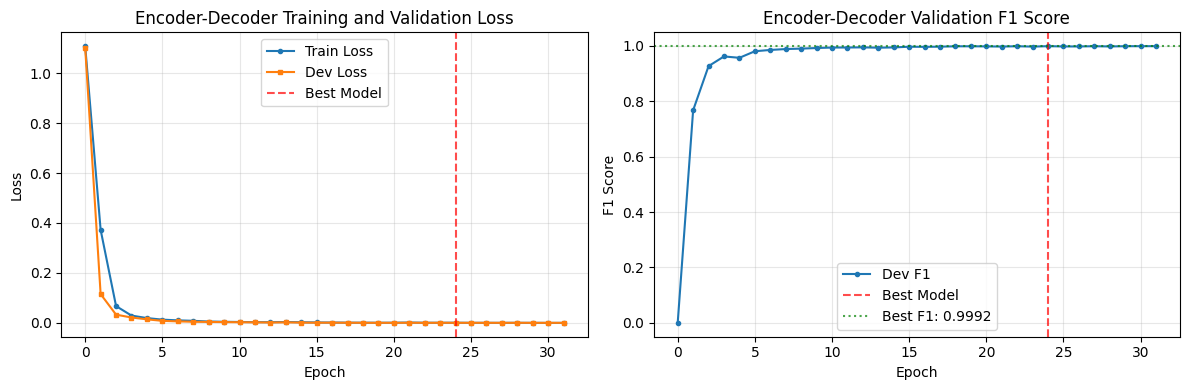

In [27]:
if __name__ == "__main__":
    main()

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load train dataset để lấy vocab + label_encoder
train_dataset = PhoNERDataset(
    './dataset/PhoNER-COVID19/train_syllable.json',
    is_train=True
)

vocab = train_dataset.vocab
label_encoder = train_dataset.label_encoder

Loaded 5027 sentences from ./dataset/PhoNER-COVID19/train_syllable.json
Vocabulary size: 3967
Number of labels: 22
Labels: ['B-AGE', 'B-DATE', 'B-GENDER', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-ORGANIZATION', 'B-PATIENT_ID', 'B-SYMPTOM_AND_DISEASE', 'B-TRANSPORTATION', 'I-AGE', 'I-DATE', 'I-GENDER', 'I-JOB', 'I-LOCATION', 'I-NAME', 'I-ORGANIZATION', 'I-PATIENT_ID', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'O']


In [29]:
vocab_size = len(vocab.word2idx)
num_labels = len(label_encoder.label2idx)

model = EncoderDecoderNER(
    vocab_size=vocab_size,
    num_labels=num_labels,
    embedding_dim=128,
    hidden_size=256
).to(device)

model.load_state_dict(
    torch.load('best_encoder_decoder_ner.pt', map_location=device)
)

model.eval()
print("Model loaded successfully")


Model loaded successfully


In [37]:
def predict_sentence(sentence, model, vocab, label_encoder, device):
    """
    sentence: string (ví dụ: "tôi học tại đại học công nghệ thông tin")
    """

    # 1. Tokenize (dataset PhoNER là syllable → split space)
    words = sentence.strip().split()

    # 2. Encode words
    encoded = torch.tensor(
        vocab.encode(words),
        dtype=torch.long
    ).unsqueeze(0).to(device)   # (1, seq_len)

    lengths = torch.tensor([len(words)]).to(device)

    # 3. Dummy labels (decoder cần input labels)
    dummy_labels = torch.zeros(
        (1, len(words)),
        dtype=torch.long
    ).to(device)

    # 4. Forward
    with torch.no_grad():
        outputs = model(encoded, dummy_labels, lengths)
        preds = torch.argmax(outputs, dim=-1)[0]

    # 5. Decode labels
    pred_labels = [
        label_encoder.idx2label[idx.item()]
        for idx in preds[:len(words)]
    ]

    fixed_labels = []
    prev = 'O'
    
    for label in pred_labels:
        if label.startswith('I-') and prev == 'O':
            label = 'O'
        fixed_labels.append(label)
        prev = label
    
    pred_labels = fixed_labels


    return list(zip(words, pred_labels))

In [43]:
sentence = "Đồng thời, bệnh viện tiếp tục thực hiện các biện pháp phòng chống dịch bệnh COVID-19 theo hướng dẫn của Bộ Y tế."


result = predict_sentence(
    sentence,
    model,
    vocab,
    label_encoder,
    device
)

for word, label in result:
    print(f"{word:15s} -> {label}")

Đồng            -> B-JOB
thời,           -> I-JOB
bệnh            -> I-JOB
viện            -> I-JOB
tiếp            -> I-JOB
tục             -> I-JOB
thực            -> I-JOB
hiện            -> I-JOB
các             -> I-JOB
biện            -> I-JOB
pháp            -> I-JOB
phòng           -> I-JOB
chống           -> I-JOB
dịch            -> I-JOB
bệnh            -> I-JOB
COVID-19        -> I-JOB
theo            -> I-JOB
hướng           -> I-JOB
dẫn             -> I-JOB
của             -> I-JOB
Bộ              -> I-JOB
Y               -> I-JOB
tế.             -> O


In [20]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from seqeval.metrics import f1_score, classification_report

############################################
# 1. DEVICE
############################################
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

############################################
# 2. VOCAB & LABEL ENCODER
############################################
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}

    def build(self, sentences):
        counter = Counter()
        for s in sentences:
            counter.update(s)

        for w in counter:
            self.word2idx[w] = len(self.word2idx)
            self.idx2word[self.word2idx[w]] = w

        print("Vocab size:", len(self.word2idx))

    def encode(self, sent):
        return [self.word2idx.get(w, 1) for w in sent]


class LabelEncoder:
    def __init__(self):
        self.label2idx = {"<PAD>": 0}
        self.idx2label = {0: "<PAD>"}

    def build(self, labels):
        uniq = set(l for seq in labels for l in seq)
        for l in sorted(uniq):
            self.label2idx[l] = len(self.label2idx)
            self.idx2label[self.label2idx[l]] = l

        print("Labels:", self.label2idx)

    def encode(self, labels):
        return [self.label2idx[l] for l in labels]


############################################
# 3. DATASET
############################################
class PhoNERDataset(Dataset):
    def __init__(self, path, vocab=None, label_encoder=None, train=False):
        self.sentences = []
        self.labels = []

        with open(path, encoding="utf-8") as f:
            for line in f:
                item = json.loads(line)
                self.sentences.append(item["words"])
                self.labels.append(item["tags"])

        if train:
            self.vocab = Vocabulary()
            self.vocab.build(self.sentences)

            self.label_encoder = LabelEncoder()
            self.label_encoder.build(self.labels)
        else:
            self.vocab = vocab
            self.label_encoder = label_encoder

        self.X = [torch.tensor(self.vocab.encode(s)) for s in self.sentences]
        self.y = [torch.tensor(self.label_encoder.encode(t)) for t in self.labels]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.sentences[idx], self.labels[idx]


def collate_fn(batch):
    X, y, words, labels = zip(*batch)
    lengths = torch.tensor([len(x) for x in X])
    X_pad = pad_sequence(X, batch_first=True, padding_value=0)
    y_pad = pad_sequence(y, batch_first=True, padding_value=0)
    return X_pad, y_pad, lengths, words, labels


############################################
# 4. MODEL (BiLSTM đơn giản – DỄ HỌC)
############################################
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        return self.fc(out)


############################################
# 5. TRAIN & EVAL
############################################
def train_epoch(model, loader, optim, loss_fn):
    model.train()
    total = 0

    for X, y, _, _, _ in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        optim.zero_grad()
        logits = model(X)

        loss = loss_fn(
            logits.view(-1, logits.size(-1)),
            y.view(-1)
        )
        loss.backward()
        optim.step()
        total += loss.item()

    return total / len(loader)


def evaluate(model, loader, label_encoder):
    model.eval()
    preds_all, gold_all = [], []

    with torch.no_grad():
        for X, y, _, words, gold in loader:
            X = X.to(DEVICE)
            logits = model(X)
            preds = torch.argmax(logits, dim=-1)

            for i in range(len(words)):
                length = len(words[i])
                preds_all.append(
                    [label_encoder.idx2label[p.item()] for p in preds[i][:length]]
                )
                gold_all.append(gold[i])

    return f1_score(gold_all, preds_all), preds_all, gold_all


############################################
# 6. TEST 1 CÂU BÌNH THƯỜNG
############################################
def predict_sentence(sentence, model, vocab, label_encoder):
    model.eval()
    tokens = sentence.split()
    ids = torch.tensor([[vocab.word2idx.get(w, 1) for w in tokens]]).to(DEVICE)

    with torch.no_grad():
        logits = model(ids)
        preds = torch.argmax(logits, dim=-1)[0]

    return list(zip(tokens, [label_encoder.idx2label[p.item()] for p in preds]))


############################################
# 7. MAIN
############################################
if __name__ == "__main__":

    # ===== PATH =====
    BASE = "./dataset/PhoNER-COVID19/"
    TRAIN = BASE + "train_syllable.json"
    DEV   = BASE + "dev_syllable.json"
    TEST  = BASE + "test_syllable.json"

    # ===== LOAD DATA =====
    train_set = PhoNERDataset(TRAIN, train=True)
    dev_set   = PhoNERDataset(DEV, vocab=train_set.vocab,
                              label_encoder=train_set.label_encoder)
    test_set  = PhoNERDataset(TEST, vocab=train_set.vocab,
                              label_encoder=train_set.label_encoder)

    train_loader = DataLoader(train_set, batch_size=32,
                              shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_set, batch_size=32,
                            collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=32,
                             collate_fn=collate_fn)

    # ===== MODEL =====
    model = BiLSTM_NER(
        vocab_size=len(train_set.vocab.word2idx),
        embed_dim=128,
        hidden_dim=256,
        num_labels=len(train_set.label_encoder.label2idx)
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    # ===== TRAIN =====
    for epoch in range(50):
        loss = train_epoch(model, train_loader, optimizer, loss_fn)
        f1, _, _ = evaluate(model, dev_loader, train_set.label_encoder)
        print(f"Epoch {epoch+1}: Loss={loss:.4f} | Dev F1={f1:.4f}")

    # ===== TEST =====
    f1, preds, gold = evaluate(model, test_loader, train_set.label_encoder)
    print("\nTEST F1:", f1)
    print(classification_report(gold, preds))

    # ===== INFERENCE =====
    print("\n🔍 TEST 1 CÂU:")
    sent = "Bác sĩ Nguyễn Trung Nguyên làm việc tại Bệnh viện Bạch Mai"
    for w, t in predict_sentence(sent, model,
                                 train_set.vocab,
                                 train_set.label_encoder):
        print(f"{w:<15} → {t}")


Using device: cuda
Vocab size: 3967
Labels: {'<PAD>': 0, 'B-AGE': 1, 'B-DATE': 2, 'B-GENDER': 3, 'B-JOB': 4, 'B-LOCATION': 5, 'B-NAME': 6, 'B-ORGANIZATION': 7, 'B-PATIENT_ID': 8, 'B-SYMPTOM_AND_DISEASE': 9, 'B-TRANSPORTATION': 10, 'I-AGE': 11, 'I-DATE': 12, 'I-GENDER': 13, 'I-JOB': 14, 'I-LOCATION': 15, 'I-NAME': 16, 'I-ORGANIZATION': 17, 'I-PATIENT_ID': 18, 'I-SYMPTOM_AND_DISEASE': 19, 'I-TRANSPORTATION': 20, 'O': 21}
Epoch 1: Loss=0.8958 | Dev F1=0.4477
Epoch 2: Loss=0.2865 | Dev F1=0.6476
Epoch 3: Loss=0.1764 | Dev F1=0.7213
Epoch 4: Loss=0.1259 | Dev F1=0.7671
Epoch 5: Loss=0.0973 | Dev F1=0.7690
Epoch 6: Loss=0.0762 | Dev F1=0.7946
Epoch 7: Loss=0.0600 | Dev F1=0.8132
Epoch 8: Loss=0.0471 | Dev F1=0.8242
Epoch 9: Loss=0.0380 | Dev F1=0.8341
Epoch 10: Loss=0.0294 | Dev F1=0.8216
Epoch 11: Loss=0.0245 | Dev F1=0.8351
Epoch 12: Loss=0.0185 | Dev F1=0.8393
Epoch 13: Loss=0.0155 | Dev F1=0.8371
Epoch 14: Loss=0.0119 | Dev F1=0.8369
Epoch 15: Loss=0.0094 | Dev F1=0.8280
Epoch 16: Loss=0

In [26]:
# ===== TEST 1 CÂU BẤT KỲ =====

sentence = "Từ 24-7 đến 31-7, bệnh nhân được mẹ là bà H.T.P (47 tuổi) đón về nhà ở phường Phước Hoà (bằng xe máy), không đi đâu chỉ ra Tạp hoá Phượng, chợ Vườn Lài, phường An Sơn cùng mẹ bán tạp hoá ở đây."

model.eval()
device = DEVICE

# --- 1. preprocess giống train ---
def preprocess_sentence(sentence):
    sentence = sentence.replace(",", " , ") \
                       .replace(".", " . ") \
                       .replace("(", " ( ") \
                       .replace(")", " ) ") \
                       .replace("-", " - ")
    return sentence.split()

words = preprocess_sentence(sentence)

# --- 2. encode ---
input_ids = [
    train_set.vocab.word2idx.get(w, train_set.vocab.word2idx["<UNK>"])
    for w in words
]

input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)

# --- 3. predict ---
with torch.no_grad():
    logits = model(input_tensor)
    preds = torch.argmax(logits, dim=-1)[0].cpu().tolist()

# --- 4. decode ---
tags = [train_set.label_encoder.idx2label[p] for p in preds]

# --- 5. print ---
print("\n🔍 KẾT QUẢ NHẬN DIỆN THỰC THỂ:\n")
for w, t in zip(words, tags):
    print(f"{w:<15} → {t}")



🔍 KẾT QUẢ NHẬN DIỆN THỰC THỂ:

Từ              → O
24              → B-DATE
-               → I-DATE
7               → I-DATE
đến             → O
31              → B-DATE
-               → I-DATE
7               → I-DATE
,               → O
bệnh            → O
nhân            → O
được            → O
mẹ              → O
là              → O
bà              → O
H               → B-NAME
.               → O
T               → O
.               → O
P               → O
(               → O
47              → O
tuổi            → O
)               → O
đón             → O
về              → O
nhà             → O
ở               → O
phường          → B-LOCATION
Phước           → I-LOCATION
Hoà             → I-LOCATION
(               → O
bằng            → O
xe              → O
máy             → O
)               → O
,               → O
không           → O
đi              → O
đâu             → O
chỉ             → O
ra              → O
Tạp             → O
hoá             → B-LOCATION
Phượng          →

In [27]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from seqeval.metrics import f1_score, classification_report

In [28]:
############################################
# 1. DEVICE
############################################
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [29]:
############################################
# 2. VOCAB & LABEL ENCODER
############################################
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}

    def build(self, sentences):
        counter = Counter()
        for s in sentences:
            counter.update(s)

        for w in counter:
            self.word2idx[w] = len(self.word2idx)
            self.idx2word[self.word2idx[w]] = w

        print("Vocab size:", len(self.word2idx))

    def encode(self, sent):
        return [self.word2idx.get(w, 1) for w in sent]

In [30]:
class LabelEncoder:
    def __init__(self):
        self.label2idx = {"<PAD>": 0}
        self.idx2label = {0: "<PAD>"}

    def build(self, labels):
        uniq = set(l for seq in labels for l in seq)
        for l in sorted(uniq):
            self.label2idx[l] = len(self.label2idx)
            self.idx2label[self.label2idx[l]] = l

        print("Labels:", self.label2idx)

    def encode(self, labels):
        return [self.label2idx[l] for l in labels]


In [31]:
############################################
# 3. DATASET
############################################
class PhoNERDataset(Dataset):
    def __init__(self, path, vocab=None, label_encoder=None, train=False):
        self.sentences = []
        self.labels = []

        with open(path, encoding="utf-8") as f:
            for line in f:
                item = json.loads(line)
                self.sentences.append(item["words"])
                self.labels.append(item["tags"])

        if train:
            self.vocab = Vocabulary()
            self.vocab.build(self.sentences)

            self.label_encoder = LabelEncoder()
            self.label_encoder.build(self.labels)
        else:
            self.vocab = vocab
            self.label_encoder = label_encoder

        self.X = [torch.tensor(self.vocab.encode(s)) for s in self.sentences]
        self.y = [torch.tensor(self.label_encoder.encode(t)) for t in self.labels]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.sentences[idx], self.labels[idx]

In [32]:
def collate_fn(batch):
    X, y, words, labels = zip(*batch)
    X_pad = pad_sequence(X, batch_first=True, padding_value=0)
    y_pad = pad_sequence(y, batch_first=True, padding_value=0)
    return X_pad, y_pad, words, labels

In [33]:
############################################
# 4. MODEL (BiLSTM)
############################################

class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.dropout(self.embedding(x))
        out, _ = self.lstm(x)
        out = self.dropout(out)
        return self.fc(out)


In [34]:
############################################
# 5. TRAIN & EVAL
############################################
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for X, y, _, _ in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(X)

        loss = loss_fn(
            logits.view(-1, logits.size(-1)),
            y.view(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

In [35]:
def evaluate(model, loader, label_encoder):
    model.eval()
    preds_all, gold_all = [], []

    with torch.no_grad():
        for X, _, words, gold in loader:
            X = X.to(DEVICE)
            logits = model(X)
            preds = torch.argmax(logits, dim=-1)

            for i in range(len(words)):
                length = len(words[i])
                preds_all.append(
                    [label_encoder.idx2label[p.item()] for p in preds[i][:length]]
                )
                gold_all.append(gold[i])

    return f1_score(gold_all, preds_all), preds_all, gold_all


In [36]:
############################################
# 6. INFERENCE
############################################
def predict_sentence(sentence, model, vocab, label_encoder):
    model.eval()
    tokens = sentence.split()
    ids = torch.tensor([[vocab.word2idx.get(w, 1) for w in tokens]]).to(DEVICE)

    with torch.no_grad():
        logits = model(ids)
        preds = torch.argmax(logits, dim=-1)[0]

    return list(zip(tokens, [label_encoder.idx2label[p.item()] for p in preds]))

In [39]:
############################################
# 7. MAIN
############################################
if __name__ == "__main__":

    # ===== PATH =====
    BASE = "./dataset/PhoNER-COVID19/"
    TRAIN = BASE + "train_syllable.json"
    DEV   = BASE + "dev_syllable.json"
    TEST  = BASE + "test_syllable.json"

    # ===== DATA =====
    train_set = PhoNERDataset(TRAIN, train=True)
    dev_set = PhoNERDataset(DEV,
                            vocab=train_set.vocab,
                            label_encoder=train_set.label_encoder)
    test_set = PhoNERDataset(TEST,
                             vocab=train_set.vocab,
                             label_encoder=train_set.label_encoder)

    train_loader = DataLoader(train_set, batch_size=32,
                              shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_set, batch_size=32,
                            collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=32,
                             collate_fn=collate_fn)

    # ===== MODEL =====
    model = BiLSTM_NER(
        vocab_size=len(train_set.vocab.word2idx),
        embed_dim=128,
        hidden_dim=256,
        num_labels=len(train_set.label_encoder.label2idx)
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    # ===== TRAIN =====
    best_f1 = 0.0
    for epoch in range(50):
        loss = train_epoch(model, train_loader, optimizer, loss_fn)
        f1, _, _ = evaluate(model, dev_loader, train_set.label_encoder)

        print(f"Epoch {epoch+1:02d} | Loss={loss:.4f} | Dev F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save({
                "model_state": model.state_dict(),
                "vocab": train_set.vocab.word2idx,
                "label2idx": train_set.label_encoder.label2idx
            }, "lstm_phoner_syllable.pt")
            print("Saved best model")

   

Vocab size: 3967
Labels: {'<PAD>': 0, 'B-AGE': 1, 'B-DATE': 2, 'B-GENDER': 3, 'B-JOB': 4, 'B-LOCATION': 5, 'B-NAME': 6, 'B-ORGANIZATION': 7, 'B-PATIENT_ID': 8, 'B-SYMPTOM_AND_DISEASE': 9, 'B-TRANSPORTATION': 10, 'I-AGE': 11, 'I-DATE': 12, 'I-GENDER': 13, 'I-JOB': 14, 'I-LOCATION': 15, 'I-NAME': 16, 'I-ORGANIZATION': 17, 'I-PATIENT_ID': 18, 'I-SYMPTOM_AND_DISEASE': 19, 'I-TRANSPORTATION': 20, 'O': 21}
Epoch 01 | Loss=0.9754 | Dev F1=0.3347
Saved best model
Epoch 02 | Loss=0.3663 | Dev F1=0.6473
Saved best model
Epoch 03 | Loss=0.2464 | Dev F1=0.7222
Saved best model
Epoch 04 | Loss=0.1927 | Dev F1=0.7636
Saved best model
Epoch 05 | Loss=0.1575 | Dev F1=0.7882
Saved best model
Epoch 06 | Loss=0.1333 | Dev F1=0.8016
Saved best model
Epoch 07 | Loss=0.1187 | Dev F1=0.8167
Saved best model
Epoch 08 | Loss=0.1036 | Dev F1=0.8263
Saved best model
Epoch 09 | Loss=0.0883 | Dev F1=0.8407
Saved best model
Epoch 10 | Loss=0.0821 | Dev F1=0.8499
Saved best model
Epoch 11 | Loss=0.0733 | Dev F1=0.85

In [40]:
 # ===== LOAD BEST MODEL =====
checkpoint = torch.load("lstm_phoner_syllable.pt", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])
model.eval()

# ===== TEST =====
f1, preds, gold = evaluate(model, test_loader, train_set.label_encoder)
print("\nTEST F1:", f1)
print(classification_report(gold, preds))

# ===== INFERENCE =====
print("TEST 1 CÂU:")
sent = "Bác sĩ Nguyễn Trung Nguyên làm việc tại Bệnh viện Bạch Mai"
for w, t in predict_sentence(sent, model,
                    train_set.vocab,
                    train_set.label_encoder):
    print(f"{w:<15} → {t}")


TEST F1: 0.8809584285835238
                     precision    recall  f1-score   support

                AGE       0.92      0.95      0.93       582
               DATE       0.96      0.97      0.96      1654
             GENDER       0.96      0.92      0.94       462
                JOB       0.51      0.47      0.49       173
           LOCATION       0.86      0.89      0.87      4441
               NAME       0.90      0.59      0.71       318
       ORGANIZATION       0.73      0.77      0.75       771
         PATIENT_ID       0.96      0.98      0.97      2005
SYMPTOM_AND_DISEASE       0.79      0.76      0.78      1136
     TRANSPORTATION       0.89      0.88      0.88       193

          micro avg       0.88      0.89      0.88     11735
          macro avg       0.85      0.82      0.83     11735
       weighted avg       0.88      0.89      0.88     11735

TEST 1 CÂU:
Bác             → O
sĩ              → O
Nguyễn          → O
Trung           → O
Nguyên          → O
là